In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/Users/omarcarr/Desktop/Notebooks/DSI-US-5/Projects/Project-2/train.csv')
kaggle = pd.read_csv('/Users/omarcarr/Desktop/Notebooks/DSI-US-5/Projects/Project-2/test.csv')

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.isnull().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       330
Lot Area             0
Street               0
Alley             1911
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
Mas Vnr Area        22
Exter Qual           0
Exter Cond           0
                  ... 
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area

# Really to be as cricket about it as possible, I should train-test split immediately:

In [5]:
features_list = [each for each in df.columns if each != 'SalePrice']

In [6]:
X = df[features_list]
y = df['SalePrice']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Let's get non-trivial:

In [8]:
top_corr = list(pd.concat([X_train, y_train],
                          axis=1).corr()
                ['SalePrice']
                .sort_values(
                    ascending=False).index[1:11])

In [9]:
top_corr

['Overall Qual',
 'Gr Liv Area',
 'Garage Cars',
 'Garage Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Mas Vnr Area']

In [10]:
X_train[top_corr].isnull().sum()

Overall Qual       0
Gr Liv Area        0
Garage Cars        0
Garage Area        0
Total Bsmt SF      1
1st Flr SF         0
Year Built         0
Year Remod/Add     0
Full Bath          0
Mas Vnr Area      18
dtype: int64

## Imputing `Mas Vnr Area` 

* The only column that currently has nulls in it, from my top-ten positively correlated columns, is `Mas Vnr Area`, which indicates the area of masonry veneer on the house. Comparing it to `Mas Vnr Type`, which the data dictionary says uses `None` for no masonry, I believe it is justified to replace the `NaN` values in this column with `0` instead. I am basing this assumption off of the data dictionary.
- I will not impute `Mas Vnr Type` at this time.

In [11]:
X_train[X_train['Mas Vnr Area'].isnull()][['Mas Vnr Area', 'Mas Vnr Type']].head()

,Mas Vnr Area,Mas Vnr Type
451,NaN,NaN
86,NaN,NaN
1941,NaN,NaN
41,NaN,NaN
1244,NaN,NaN


In [12]:
# confirming `Mas Vnr Area` is a numerical value:
X_train['Mas Vnr Area'].value_counts().head()

0.0      913
120.0     10
210.0      8
200.0      8
16.0       8
Name: Mas Vnr Area, dtype: int64

In [13]:
X_train[['Mas Vnr Area']] = X_train[['Mas Vnr Area']].fillna(0.0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
X_train[top_corr].isnull().sum()

Overall Qual      0
Gr Liv Area       0
Garage Cars       0
Garage Area       0
Total Bsmt SF     1
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      0
dtype: int64

# Imputing `Total Bsmt SF`

In [15]:
X_train[X_train['Total Bsmt SF'].isnull()]#.fillna(0.0)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD


In [16]:
X_train.loc[1327, 'Total Bsmt SF'] = 0

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
X_train[top_corr].isnull().sum()

Overall Qual      0
Gr Liv Area       0
Garage Cars       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      0
dtype: int64

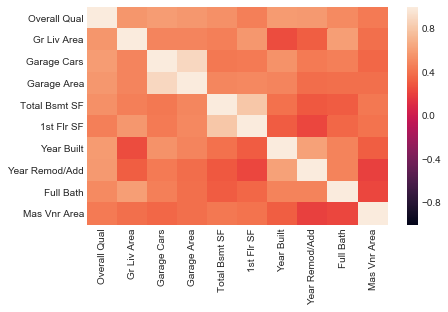

In [18]:
sns.heatmap(X_train[top_corr].corr(), vmin=-1, vmax=1);

# Sanitize `X_test`

In [19]:
X_test[top_corr].isnull().sum()

Overall Qual      0
Gr Liv Area       0
Garage Cars       1
Garage Area       1
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      4
dtype: int64

In [20]:
X_test['Garage Area'] = X_test['Garage Area'].fillna(0.0)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [21]:
X_test['Garage Cars'] = X_test['Garage Cars'].fillna(0.0)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
X_test['Mas Vnr Area'] = X_test['Mas Vnr Area'].fillna(0.0)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
X_train[top_corr].isnull().sum()

Overall Qual      0
Gr Liv Area       0
Garage Cars       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      0
dtype: int64

In [24]:
X_test[top_corr].isnull().sum()

Overall Qual      0
Gr Liv Area       0
Garage Cars       0
Garage Area       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      0
dtype: int64

# Let's try `StandardScaler`

###### And then some models

In [25]:
# for the sake of my workflow, I'm overwriting X_train and X_test
# hopefully i do not regret this
# i might

X_train = X_train[top_corr]
X_test = X_test[top_corr]

In [26]:
ss = StandardScaler()

ss.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

# Models

In [28]:
lr = LinearRegression()

lr.fit(X_train_s, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
lr.score(X_train_s, y_train)

0.7820445322961062

In [30]:
lr.score(X_test_s, y_test)

0.842577001357457

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
mean_squared_error(y_test, lr.predict(X_test_s)) ** 0.5

31089.887500357992

# Refit on full dataset

In [33]:
X[top_corr].isnull().sum()

Overall Qual       0
Gr Liv Area        0
Garage Cars        1
Garage Area        1
Total Bsmt SF      1
1st Flr SF         0
Year Built         0
Year Remod/Add     0
Full Bath          0
Mas Vnr Area      22
dtype: int64

In [34]:
X_new = X[top_corr].fillna(0.0)

In [35]:
ss = StandardScaler()

ss.fit(X_new)
X_new_s = ss.transform(X_new)

In [36]:
lr = LinearRegression()

lr.fit(X_new_s, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
kaggle_new = kaggle[top_corr].fillna(0.0)

In [38]:
kaggle_new_s = ss.transform(kaggle_new)

In [39]:
preds = lr.predict(kaggle_new_s)

# What Did We Just Do >:(

1. Imported the data and did a train-test split WITH A RANDOM STATE FOR REPRODUCIBILITY OF RESULTS *AND* MINIMIZATION OF HEADACHES
2. To simulate the process of building a model on known data and testing it on unknown data, we examined correlations just among the training data
3. We cleaned the training data
    - Optional: dummies
3. We fit a scaler to the training data
3. We transformed the training data
4. We cleaned the testing data
4. We transformed the testing data with the scaler fit on the training data
5. We fit a model to the scaled training data
6. We scored the model on the scaled training and scaled testing data
7. **Because the model performed reasonably well**, we went ahead and refit it on **all** of the `train.csv` data, including fitting a scaler to all of the train data
8. We cleaned and transformed the kaggle data
9. We used our model trained on all the data to make predictions off the kaggle `test.csv`

# Formatting for Submission

In [40]:
submission = pd.DataFrame(preds, columns=['SalePrice'])

In [41]:
submission['Id'] = kaggle['Id']

In [42]:
import datetime

In [43]:
now = str(datetime.datetime.now())[:19]

In [44]:
# kaggle_new.head()

# kaggle.head()

# preds[:5]

In [45]:
submission[['Id', 'SalePrice']].to_csv(f'kaggle_submission_{now}', index=False)

In [46]:
submission.head()

,SalePrice,Id
0,154793.658368,2658
1,205851.298218,2718
2,192470.896583,2414
3,130040.436391,1989
4,185943.288343,625


In [47]:
submission.tail()

,SalePrice,Id
874,187147.383909,1662
875,216659.033738,1234
876,129979.032537,1373
877,101699.698766,1672
878,105964.276548,1939


# Now with 110% more Pipelines

- Current `X_train` has not been standardized, so we'll be putting that inside our pipeline

In [55]:
from sklearn.preprocessing import PolynomialFeatures

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, Lasso

pipe = Pipeline([
    ('pf', PolynomialFeatures()),
    ('ss', StandardScaler()),
    ('lcv', LassoCV(n_alphas=500))
])

pipe.fit(X_train, y_train)

print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.7953818089320644
0.8408534341702584


In [52]:
max(pipe.named_steps['lcv'].alphas_)

63288.68272864421

In [54]:
list(zip(pipe.named_steps['lcv'].coef_, X_train.columns))

[(28342.897784647856, 'Overall Qual'),
 (20090.073650353745, 'Gr Liv Area'),
 (5229.423301248439, 'Garage Cars'),
 (5116.245410517976, 'Garage Area'),
 (5944.983342186712, 'Total Bsmt SF'),
 (5343.747231673706, '1st Flr SF'),
 (5159.561737226463, 'Year Built'),
 (6546.4080786651175, 'Year Remod/Add'),
 (0.0, 'Full Bath'),
 (6744.256512993174, 'Mas Vnr Area')]

In [63]:
pd.DataFrame({
    'coefs': pipe.named_steps['pf'].get_feature_names(X_train.columns),
    'vals': pipe.named_steps['lcv'].coef_
}).set_index('coefs').sort_values('vals', ascending=False)

,vals
coefs,
Overall Qual Gr Liv Area,20039.842998
Overall Qual^2,18653.825937
Overall Qual Garage Cars,7833.817277
Year Built Year Remod/Add,6933.998447
Gr Liv Area Garage Cars,6182.436294
Garage Cars Total Bsmt SF,5949.967465
Garage Cars Mas Vnr Area,4583.383158
1st Flr SF Year Remod/Add,3856.794951
Gr Liv Area Full Bath,1193.361283
